In [1237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Tuple, Dict, Any, Optional

In [1238]:
df_probabilities = pd.read_csv('./Datasets/pi_rating_probabilities.csv')
df_games = pd.read_csv('./Datasets/premier/full_df.csv')
df_teams = pd.read_csv('./Datasets/premier/df_teams.csv')

df_games["Date"] = pd.to_datetime(df_games["Date"], format="%d/%m/%Y")


In [1239]:
df_teams.head()

,TEAM,H_RATING,A_RATING
0,Reading,-0.233066,-0.633626
1,Birmingham,-0.348054,-0.518068
2,Brentford,0.782183,0.527181
3,Bristol City,-0.079043,-0.246359
4,Ipswich,0.097942,-0.167536


In [1240]:
df_probabilities.head()


,BIN_LEFT,BIN_RIGHT,COUNT,H_WINS,DRAWS,A_WINS
0,-3.186749,-0.694304,46,0.217391,0.326087,0.456522
1,-0.694304,-0.497326,78,0.282051,0.230769,0.487179
2,-0.497326,-0.398837,75,0.253333,0.266667,0.480000
3,-0.398837,-0.300348,126,0.388889,0.238095,0.373016
4,-0.300348,-0.201858,174,0.327586,0.224138,0.448276


In [1241]:
def get_probabilities(rating_diff: int) -> Tuple[float, float, float]:

  min_rating_diff = df_probabilities["BIN_LEFT"].min()
  max_rating_diff = df_probabilities["BIN_RIGHT"].max()

  if rating_diff < min_rating_diff:
    return (0, 0, 1)
  elif rating_diff > max_rating_diff:
    return (1, 0, 0)

  for _, row in df_probabilities.iterrows():
    bin_start, bin_end = row["BIN_LEFT"], row["BIN_RIGHT"]
    if bin_start < rating_diff <= bin_end:
      return (row["H_WINS"], row["DRAWS"], row["A_WINS"])

""""
odds has the following format, example:
{
  "H": 1.5,
  "D": 3.5,
  "A": 2.5
}
"""
def get_evs(rating_diff: int, odds: Dict[str, float]) -> Dict[str, float]:
  p_H, p_D, p_A = get_probabilities(rating_diff)

  # find best odds between bookies, use the column with the bookie name concatenated with "H", "D" or "A"
  odds_H = odds["H"]
  odds_D = odds["D"]
  odds_A = odds["A"]

  print(f"p_H: {p_H}, p_D: {p_D}, p_A: {p_A}")
  print(f"odds_H: {odds_H}, odds_D: {odds_D}, odds_A: {odds_A}")
  ev_H = (odds_H - 1) * p_H - (1 - p_H)
  ev_D = (odds_D - 1) * p_D - (1 - p_D)
  ev_A = (odds_A - 1) * p_A - (1 - p_A)

  return {"H": ev_H, "D": ev_D, "A": ev_A}

get_probabilities(0)

(0.3956043956043956, 0.3049450549450549, 0.2994505494505494)

In [1242]:
INITIAL_BANKROLL = 100
BANKROLL_HISTORY = [INITIAL_BANKROLL]

P_LOWER_THRESHOLD = 0.3
P_UPPER_THRESHOLD = 0.6
EV_LOWER_THRESHOLD = 0.05
EV_UPPER_THRESHOLD = 0.7

df_games["BET"] = ""
df_games["EV"] = 0
df_games["PROB"] = 0

BOOKIES = ["B365"]

# random sample of 1000 games
df_games_sample = df_games.tail(380)

for index, row in df_games_sample.iterrows():
  rating_diff = row["RATING_DIFF"]
  p_H, p_D, p_A = get_probabilities(rating_diff)

  # find best odds between bookies, use the column with the bookie name concatenated with "H", "D" or "A"
  odds_H = [float(row[bookie + "H"]) for bookie in BOOKIES]
  odds_D = [float(row[bookie + "D"]) for bookie in BOOKIES]
  odds_A = [float(row[bookie + "A"]) for bookie in BOOKIES]


  best_odds_H = max(odds_H)
  best_odds_D = max(odds_D)
  best_odds_A = max(odds_A) 


  ev_H = (best_odds_H - 1) * p_H - (1 - p_H)
  ev_D = (best_odds_D - 1) * p_D - (1 - p_D)
  ev_A = (best_odds_A - 1) * p_A - (1 - p_A)

  choice = "H" if ev_H > ev_D and ev_H > ev_A else "D" if ev_D > ev_H and ev_D > ev_A else "A"
  p_choice = p_H if choice == "H" else p_D if choice == "D" else p_A
  ev_choice = ev_H if choice == "H" else ev_D if choice == "D" else ev_A


  if max(ev_H, ev_D, ev_A) > EV_LOWER_THRESHOLD and p_choice > P_LOWER_THRESHOLD and p_choice < P_UPPER_THRESHOLD and max(ev_H, ev_D, ev_A) < EV_UPPER_THRESHOLD:
    if ev_H > ev_D and ev_H > ev_A:
      df_games_sample.loc[index, "BET"] = choice
      df_games_sample.loc[index, "EV"] = ev_choice
      df_games_sample.loc[index, "PROB"] = p_choice
    elif ev_D > ev_H and ev_D > ev_A:
      df_games_sample.loc[index, "BET"] = choice
      df_games_sample.loc[index, "EV"] = ev_choice
      df_games_sample.loc[index, "PROB"] = p_choice
    elif ev_A > ev_H and ev_A > ev_D:
      df_games_sample.loc[index, "BET"] = choice
      df_games_sample.loc[index, "EV"] = ev_choice
      df_games_sample.loc[index, "PROB"] = p_choice
  else:
    continue

  bet_size = 5

  if df_games_sample.loc[index, "BET"] == df_games_sample.loc[index, "FTR"] and df_games_sample.loc[index, "BET"] == "H":
    BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] + bet_size * (best_odds_H - 1))
  elif df_games_sample.loc[index, "BET"] == df_games_sample.loc[index, "FTR"] and df_games_sample.loc[index, "BET"] == "D":
    BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] + bet_size * (best_odds_D - 1))
  elif df_games_sample.loc[index, "BET"] == df_games_sample.loc[index, "FTR"] and df_games_sample.loc[index, "BET"] == "A":
    BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] + bet_size * (best_odds_A - 1))
  else:
    BANKROLL_HISTORY.append(BANKROLL_HISTORY[-1] - bet_size)

C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\3379081107.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06689655172413789' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_games_sample.loc[index, "EV"] = ev_choice
C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\3379081107.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4482758620689655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_games_sample.loc[index, "PROB"] = p_choice


In [1243]:
# Now lets create a user interface to check this week's games and bet on them using ipywidgets
# Create two fields to select the Home team and the Away team
# Then add a field to input the decimal odds for each result
# then print if I should bet or not based on the previous code and what should I bet on

import ipywidgets as widgets
from IPython.display import display

home_team = widgets.Dropdown(
    options=df_games_sample["HomeTeam"].unique(),
    description='Home team:',
    disabled=False,
)

away_team = widgets.Dropdown(
    options=df_games_sample["AwayTeam"].unique(),
    description='Away team:',
    disabled=False,
)

odds_H = widgets.FloatText(
    value=1.0,
    description='Odds H:',
    disabled=False
)

odds_D = widgets.FloatText(
    value=1.0,
    description='Odds D:',
    disabled=False
)

odds_A = widgets.FloatText(
    value=1.0,
    description='Odds A:',
    disabled=False
)

display(home_team, away_team, odds_H, odds_D, odds_A)


def on_button_clicked(b):
    home_team_name = home_team.value
    away_team_name = away_team.value
    odds_H_value = odds_H.value
    odds_D_value = odds_D.value
    odds_A_value = odds_A.value
    
    # print house edge
    print("House edge: ", 1 / odds_H_value + 1 / odds_D_value + 1 / odds_A_value - 1)

    home_team_rating = df_teams[df_teams["TEAM"] == home_team_name]["H_RATING"].values[0]
    away_team_rating = df_teams[df_teams["TEAM"] == away_team_name]["A_RATING"].values[0]
    rating_diff = home_team_rating - away_team_rating

    print("Home team rating: ", home_team_rating)
    print("Away team rating: ", away_team_rating)
    print("Rating diff: ", rating_diff)
    
    p_H, p_D, p_A = get_probabilities(rating_diff)
    print(f"Probabilities: H: {p_H}, D: {p_D}, A: {p_A}")
    print(f"House probabilities: H: {1 / odds_H_value}, D: {1 / odds_D_value}, A: {1 / odds_A_value}")

    evs = get_evs(rating_diff, {"H": odds_H_value, "D": odds_D_value, "A": odds_A_value})
    print(f"EVs: H: {evs['H']}, D: {evs['D']}, A: {evs['A']}")
    
    choice = "H" if evs["H"] > evs["D"] and evs["H"] > evs["A"] else "D" if evs["D"] > evs["H"] and evs["D"] > evs["A"] else "A"
    p_choice = p_H if choice == "H" else p_D if choice == "D" else p_A
    ev_choice = ev_H if choice == "H" else ev_D if choice == "D" else ev_A
    
    if max(evs["H"], evs["D"], evs["A"]) > EV_LOWER_THRESHOLD and max(evs["H"], evs["D"], evs["A"]) < EV_UPPER_THRESHOLD and p_choice > P_LOWER_THRESHOLD and p_choice < P_UPPER_THRESHOLD:
        if evs["H"] > evs["D"] and evs["H"] > evs["A"]:
            print("Bet on Home team, " + home_team_name)
        elif evs["D"] > evs["H"] and evs["D"] > evs["A"]:
            print("Bet on Draw")
        elif evs["A"] > evs["H"] and evs["A"] > evs["D"]:
            print("Bet on Away team, " + away_team_name)
    else:
        print("No bet")

button = widgets.Button(description="Check bet")
display(button)
button.on_click(on_button_clicked)



Dropdown(description='Home team:', options=('Wigan', 'Middlesbrough', 'Blackburn', 'Cardiff', 'Huddersfield', …

Dropdown(description='Away team:', options=('Coventry', 'Stoke', 'Reading', 'West Brom', 'Norwich', 'Burnley',…

FloatText(value=1.0, description='Odds H:')

FloatText(value=1.0, description='Odds D:')

FloatText(value=1.0, description='Odds A:')

Button(description='Check bet', style=ButtonStyle())

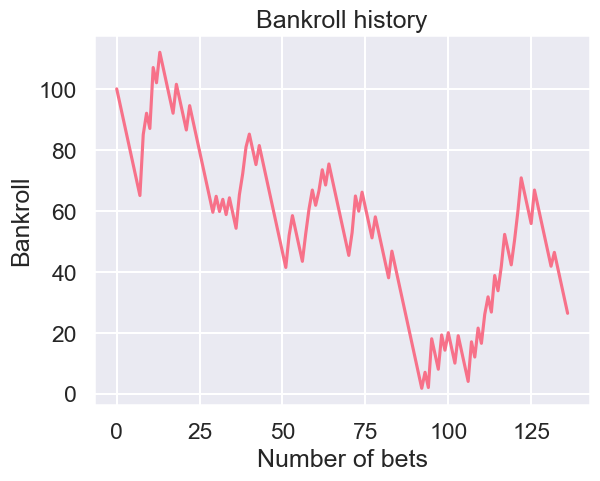

In [1244]:
# Visualize bankroll history elegantly
plt.plot(BANKROLL_HISTORY)
plt.xlabel("Number of bets")
plt.ylabel("Bankroll")
plt.title("Bankroll history")
plt.show()

C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\1151538386.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_sample["BET_WON"] = df_games_sample["BET"] == df_games_sample["FTR"]
C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\1151538386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_sample["BET_WON"] = df_games_sample["BET_WON"].astype(int)


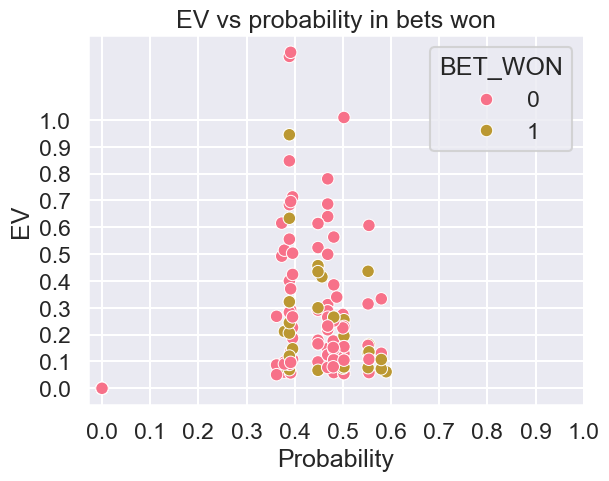

Text(0.5, 1.0, 'Odds vs probability in bets won')

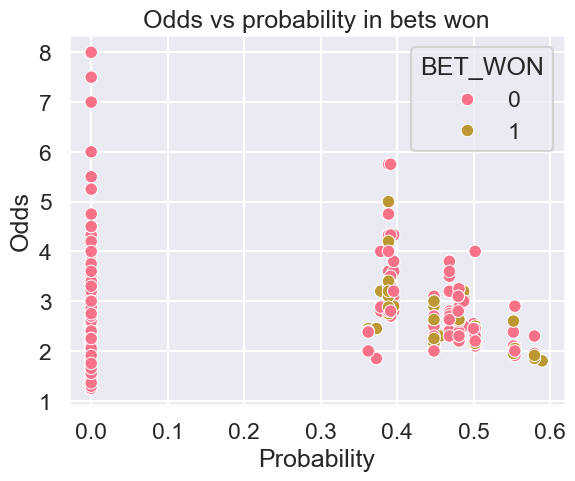

In [1245]:
# Plot EV vs probability in bets won
# take into account that there are a lot of bets when choosing the plot and color palette

df_games_sample["BET_WON"] = df_games_sample["BET"] == df_games_sample["FTR"]
df_games_sample["BET_WON"] = df_games_sample["BET_WON"].astype(int)
df_games_sample["BET_WON"].value_counts()

# plot
sns.scatterplot(x="PROB", y="EV", hue="BET_WON", data=df_games_sample)
plt.xlabel("Probability")
plt.ylabel("EV")
plt.title("EV vs probability in bets won")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

# Bar chart of odds vs probability in bets won, 10 bins
sns.scatterplot(x="PROB", y="B365H", hue="BET_WON", data=df_games_sample)
plt.xlabel("Probability")
plt.ylabel("Odds")
plt.grid(True)
plt.title("Odds vs probability in bets won")


In [1246]:
# Sum of EVs where BET is H, D or A
sum_ev = df_games_sample[df_games_sample["BET"] != ""]["EV"].sum()
sum_ev



37.85684640186167

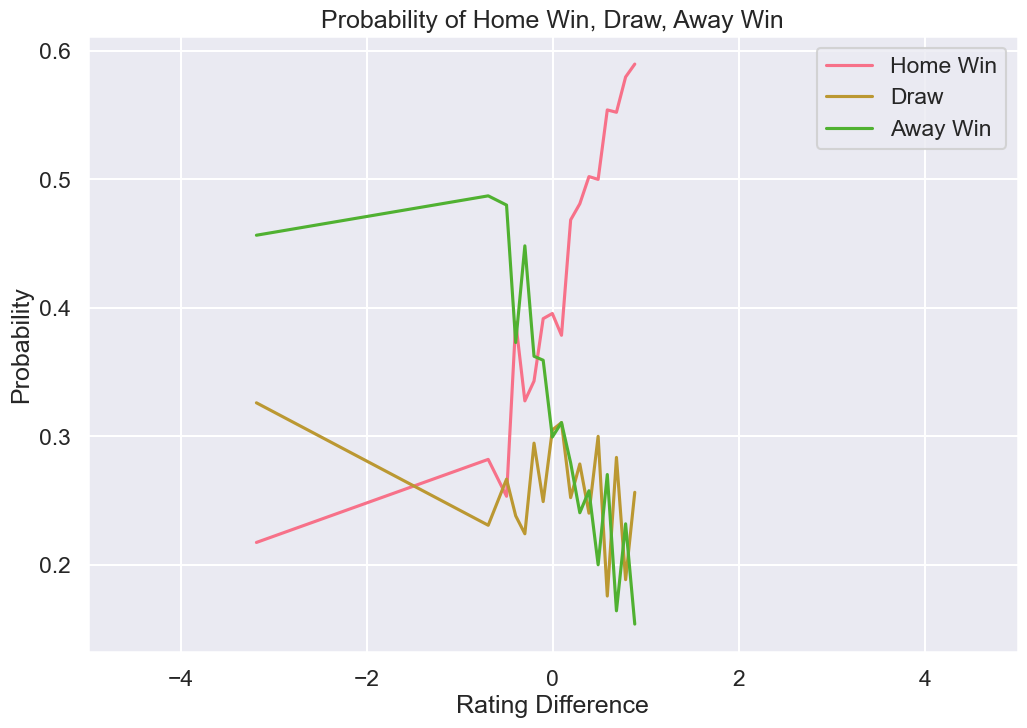

In [1247]:
# visualize the relationship between the rating difference and the probability of the home team winning

plt.figure(figsize=(12, 8))
plt.plot(df_probabilities["BIN_LEFT"], df_probabilities["H_WINS"], label="Home Win")
plt.plot(df_probabilities["BIN_LEFT"], df_probabilities["DRAWS"], label="Draw")
plt.plot(df_probabilities["BIN_LEFT"], df_probabilities["A_WINS"], label="Away Win")
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("husl")

# center arount 0, add a title and axis labels
plt.xlim(-5, 5)
plt.title("Probability of Home Win, Draw, Away Win")
plt.xlabel("Rating Difference")
plt.ylabel("Probability")
plt.legend()
plt.show()


In [1248]:
df_games_sample.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'RATING_DIFF', 'H_RATING', 'A_RATING',
       'BET', 'EV', 'PROB', 'BET_WON'],
      dtype='object', length=132)

In [1249]:
# Plot bets lost by month / games with bets by month
df_games_sample["Date"] = pd.to_datetime(df_games_sample["Date"], format="%d/%m/%Y")
df_games_sample["Month"] = df_games_sample["Date"].dt.month

df_games_sample["BET_LOST"] = df_games_sample[["BET", "FTR"]].apply(lambda x: 1 if x["BET"] != x["FTR"] and x["BET"] != "" else 0, axis=1)
df_games_sample["BET_LOST"] = df_games_sample["BET_LOST"].astype(int)
df_games_sample["BET_LOST"].value_counts()

#df_games_by_month ignoring games with BET = ""
df_games_by_month = df_games_sample[df_games_sample["BET"] != ""].groupby("Month").agg({"BET_LOST": "sum", "BET": "count"})
df_games_by_month["LOST_RATIO"] = df_games_by_month["BET_LOST"] / df_games_by_month["BET"]
df_games_by_month

C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\1829530497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_sample["Date"] = pd.to_datetime(df_games_sample["Date"], format="%d/%m/%Y")
C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\1829530497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games_sample["Month"] = df_games_sample["Date"].dt.month
C:\Users\sauce\AppData\Local\Temp\ipykernel_19628\1829530497.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,BET_LOST,BET,LOST_RATIO
Month,,,
3,5,5,1.000000
4,19,27,0.703704
5,3,6,0.500000
8,12,17,0.705882
9,14,24,0.583333
10,15,18,0.833333
11,10,20,0.500000
12,14,19,0.736842
